# Using scTour to infer cellular dynamics for LARRY

In [2]:
import sys  
sys.path.insert(0, '/Users/ruitong/scDiffEq')
from functions import *
from sctour_simulation import *
import sctour as sct

In [4]:
os. getcwd()

'/Volumes/GoogleDrive-102948143750648171876/My Drive/PhD/Docs/Academic/Rotations/Gaddy_Rotation/mv_scDiffEq/scTour_Explore'

In [104]:
proc = trainSet = Train_Visu = False

In [4]:
if proc:
    h5ad_path = "../ProcData/Weinreb2020_WholeProc.h5ad" # substitute the obs
    ### Annotate data splitting
    adata = cf.io.read_h5ad(h5ad_path)
    cf.pp.annotate_train_test(adata)
    cf.pp.annnotate_unique_test_train_lineages(adata)
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
    adata.write_h5ad("../ProcData/Weinreb2020_WholeAnnot.h5ad")
    TrueSet = adata.obs.dropna()
    TrueSet =((TrueSet.test)&(TrueSet.early_neu_mo==1)&(TrueSet.has_fate_mask == 1)&(TrueSet.unique_test_lineage))
    pickle.dump(TrueSet, file = open("../ProcData/RestrictedTest.pickle", "wb"))
    adata_train = adata[adata.obs["train"]].copy()
    ### 20k sampling
    np.random.seed(123)
    repSample = [np.random.choice(adata_train.obs.index, 20_000, replace=False) for i in range(10)]
    sample_idx = repSample[2]
    adata_T1 = adata_train[sample_idx].copy()
    adata_T1.obs = adata_T1.obs.reset_index()
    ### Training Embedding
    sc.pp.pca(adata_T1)
    sc.pp.neighbors(adata_T1, n_neighbors=50) ### build KNN graph
    sc.tl.umap(adata_T1, min_dist=0.1)### Generate UMAP embedding with latent space
    adata_T1 = adata_T1[:,adata_T1.var.highly_variable]
    adata_T1.write_h5ad("../ProcData/Weinreb2020_TrainSet2.h5ad")

In [5]:
if trainSet:
    adata_T1 = ann.read_h5ad("../ProcData/Weinreb2020_TrainSet2.h5ad")
    tnode = sct.train.Trainer(adata_T1, loss_mode='nb',nepoch=400,n_latent=10)
    tnode.train()
    pickle.dump(tnode, file = open("tnode_20k2_l10.pickle", "wb"))

In [6]:
if Train_Visu:
    adata_T1.obs['ptime'] = sct.train.reverse_time(tnode.get_time())
    mix_zs,zs,pred_zs = tnode.get_latentsp(alpha_z=0.2, alpha_predz=0.8)
    adata_T1.obsm['X_TNODE'] = mix_zs
    sc.pl.violin(adata_T1, keys=["ptime"], groupby="Annotation", rotation=90,resolution=0.7)

Generate a UMAP embedding based on the inferred latent space. Optionally, you can order the cells according to their pseudotime before this step, which is demonstrated to yield a better trajectory.

In [7]:
if Train_Visu:
    adata_T1 = adata_T1[np.argsort(adata_T1.obs['ptime']),:]
    sc.pp.neighbors(adata_T1, use_rep='X_TNODE', n_neighbors=50) ### build KNN graph
    sc.tl.umap(adata_T1, min_dist=0.1)### Generate UMAP embedding with latent space
    adata_T1.obsm['X_VF'] = tnode.get_vector_field(adata_T1.obs['ptime'].values, adata_T1.obsm['X_TNODE'])

In [8]:
%matplotlib inline
if Train_Visu:
    fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))
    sc.pl.umap(adata_T1, color='Annotation', size=10, ax=axs[0], legend_loc='on data', show=False)
    sc.pl.umap(adata_T1, color='ptime', size=20, ax=axs[1], show=False)
    sct.vf.plot_vector_field(adata_T1, zs_key='TNODE', vf_key='VF', use_rep_neigh='TNODE',reverse=True,
                             color='Annotation', ax=axs[2], legend_loc='none', frameon=False, size=100, alpha=0.2)
    plt.show()                                       

In [110]:
#test dataset 1
#test1_pred_t is the predicted pseudotime, and test1_pred_ltsp is the predicted latent space.
tnode = pickle.load(open("tnode_20k2_l10.pickle", "rb"))
h5ad_path = "../ProcData/Weinreb2020_WholeAnnot.h5ad"
adata = ann.read_h5ad(h5ad_path)
adata_test1 = adata[adata.obs["test"]].copy()
test1_pred_t, test1_pred_ltsp, _, _ = tnode.predict_time(adata_test1, alpha_z=0.2, 
                                                         alpha_predz=0.8, mode='coarse')
adata_test1.obs['ptime'] = 1-test1_pred_t
adata_test1.obsm['X_TNODE'] = test1_pred_ltsp
DR(adata_test1)

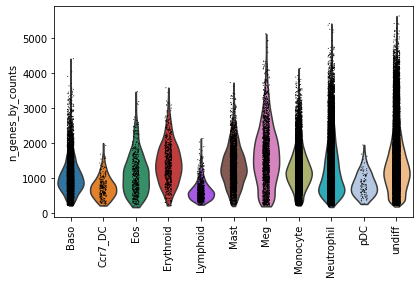

In [10]:
sc.pl.violin(adata, keys=["n_genes_by_counts"], groupby="Annotation", rotation=90,resolution=0.7)

<AxesSubplot:title={'center':'Annotation'}, xlabel='UMAP1', ylabel='UMAP2'>

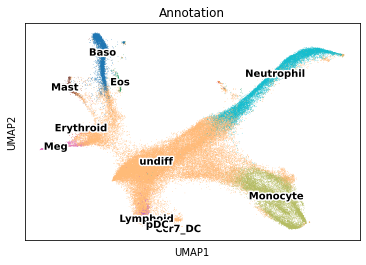

In [111]:
sc.pl.umap(adata_test1, color='Annotation', legend_loc='on data',show=False,
           legend_fontoutline=3)

In [106]:
TrueTest = pickle.load(open("../ProcData/RestrictedTest.pickle", "rb"))
TestIndex = TrueTest[TrueTest].index
TestClone = adata_test1.obs.loc[TestIndex,"clone_idx"]
dfTest = adata_test1.obs[adata_test1.obs.clone_idx.isin(TestClone)]
ByCloneCor = dfTest.groupby("clone_idx")[['Time point','ptime']].corr().unstack().iloc[:,1].dropna()

In [57]:
TestIndex

Index(['13371', '13483', '13760', '13887', '14020', '14089', '14106', '14348',
       '15012', '15119',
       ...
       '60572', '60743', '60814', '61355', '61379', '61463', '61520', '61796',
       '68574', '69113'],
      dtype='object', length=266)

In [113]:
TestClone["15012"]

3530.0

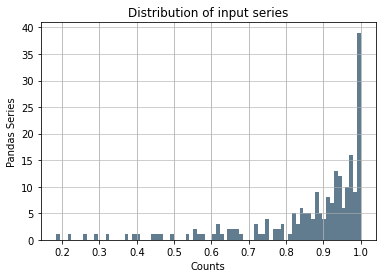

In [35]:
quickHist(ByCloneCor)

In [70]:
Annsub = adata_test1[adata_test1.obs.clone_idx.isin(TestClone)].copy()

In [76]:
Annsub

AnnData object with n_obs × n_vars = 2532 × 21043
    obs: 'Time point', 'Population', 'Annotation', 'Well', 'cell_idx', 'clone_idx', 'cytotrace', 'cytotrace_rank', 'cytotrace_GCS', 'neu_mo_mask', 'smoothed_groundtruth_from_heldout', 'PBA_predictions', 'FateID_predictions', 'WOT_predictions', 'early_cells', 'heldout_mask', 'outliers', 'has_fate_mask', 'early_neu_mo', 'neu_vs_mo_percent', 'train', 'test', 'unique_train_lineage', 'unique_test_lineage', 'n_genes_by_counts', 'total_counts', 'ptime'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'hvg', 'log1p'
    obsm: 'X_TNODE'

In [ ]:
sc.pl.violin(Annsub, keys=["n_genes_by_counts"], groupby=["Annotation"], rotation=90,resolution=0.7)

In [100]:
sumDF = Annsub.obs.groupby(["clone_idx","Time point","Annotation"]).size()
sumDF = sumDF[sumDF>3]

In [101]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    
    print(sumDF)

clone_idx  Time point  Annotation
5.0        6.0         Monocyte       4
50.0       6.0         Neutrophil     4
159.0      4.0         undiff         5
188.0      6.0         undiff         7
191.0      2.0         undiff         4
           4.0         undiff         8
           6.0         Neutrophil    10
                       undiff         7
201.0      6.0         Neutrophil     6
331.0      6.0         Monocyte       4
375.0      4.0         undiff         4
           6.0         Monocyte       8
407.0      4.0         Neutrophil     8
                       undiff         8
           6.0         Neutrophil    12
417.0      4.0         Monocyte       5
                       Neutrophil     7
                       undiff        14
           6.0         Monocyte       5
                       Neutrophil    21
506.0      6.0         Neutrophil     5
529.0      4.0         Monocyte       4
                       undiff         9
           6.0         Monocyte      24
      

In [ ]:
sc.pl.violin(Annsub, keys=["n_genes_by_counts"], groupby=["Annotation"], rotation=90,resolution=0.7)

Fate Bias:0.591


Neutrophil    233
Monocyte      161
Name: Annotation, dtype: int64

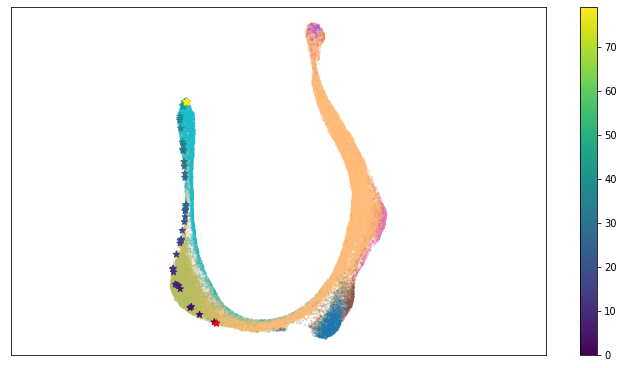

In [175]:
chain_simu(adata_test1,"68857",tnode)

Fate Bias:0.686


Neutrophil    70
Monocyte      32
Name: Annotation, dtype: int64

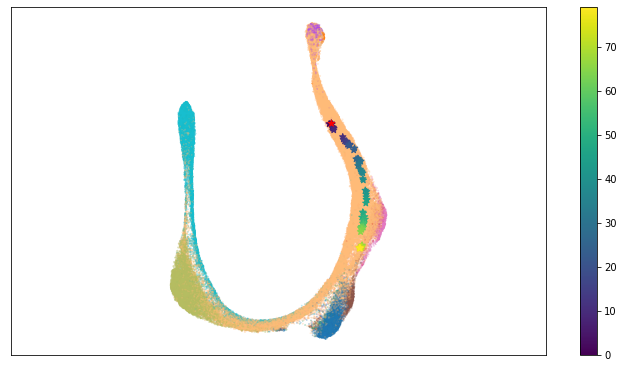

In [177]:
chain_simu(adata_test1,"60814",tnode)

Fate Bias:0.538


Neutrophil    70
Monocyte      60
Name: Annotation, dtype: int64

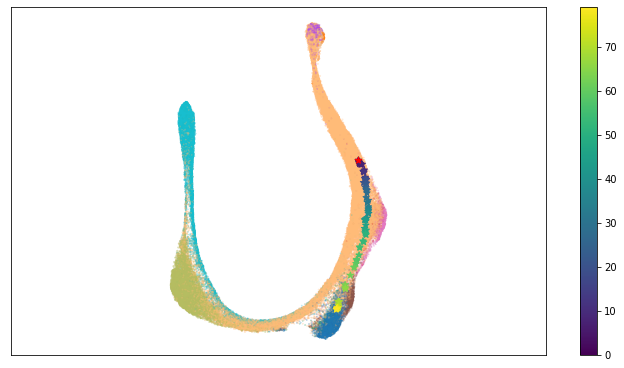

In [178]:
chain_simu(adata_test1,"15012",tnode)

In [128]:
'''
Utils for testing sctour
'''
from scipy.spatial import distance
from torchdiffeq import odeint
import umap
import numpy as np
import torch
import matplotlib.pyplot as plt
device = "cpu"

def vec_dist(a,vec):
    return distance.euclidean(a,vec[-1])
def Simulate(D,trainedM,ind,n):
    z0 = D.obsm['X_TNODE'][ind]
    model = trainedM.get_model(None)
    t_init = D.obs["ptime"][ind]
    tstep = D.obs.ptime[D.obs.ptime<t_init].to_numpy()
    t_np = np.random.choice(tstep,replace=False,size=n)
    t_np = np.flip(np.sort(t_np)).copy()
    t = torch.Tensor(t_np).to(device)
    if not ((t[1:] > t[:-1]).all())|((t[1:] < t[:-1]).all()):
        t_np = np.linspace(t_init,0,n)
        t = torch.Tensor(t_np).to(device)
    z0 = torch.Tensor(z0).to(device)
    pred_z = odeint(model.lode_func,z0,t,method = model.ode_method).view(-1, model.n_latent)
    x_pred_ = pred_z.detach().cpu().numpy()
    euDist = np.apply_along_axis(vec_dist,1,D.obsm['X_TNODE'],vec=x_pred_)
    idx = np.argpartition(euDist, 50)
    FateSeries = D.obs[idx<50].Annotation.value_counts()[["Neutrophil","Monocyte"]]
    return x_pred_,FateSeries
def fateBias(D,ind,trainedM,n,r=25):
    x_pred_ = Simulate(D,trainedM,ind,n)[0]
    FateSeries = sum([Simulate(D,trainedM,ind,n)[1] for k in range(r)])
    fateBias = ((FateSeries[0])/(FateSeries[0]+FateSeries[1]+1)).round(3)
    return fateBias,FateSeries,x_pred_
def trajectory_simu(D,vec,pickelUMAP=None,sort=False):
    if sort:
        D = D[np.argsort(D.obs['ptime'].values), :]
    if pickelUMAP is None:
        testUMAP = umap.UMAP(random_state=42)
        vae_embedding_umap = testUMAP.fit_transform(D.obsm['X_TNODE'])
    else:
        testUMAP = pickle.load(open(pickelUMAP, "rb"))
        vae_embedding_umap = testUMAP.transform(D.obsm['X_TNODE'])
    vae_embedding_progress_umap = testUMAP.transform(vec)
    plt.figure(figsize=(12, 6.4))
    plt.scatter(vae_embedding_umap[:, 0], 
                vae_embedding_umap[:, 1], 
                c=np.array(D.uns["Annotation_colors"])[D.obs.Annotation.cat.codes.to_numpy()],
                s=1, 
                marker="*",
                alpha=0.22)
    plt.scatter(vae_embedding_progress_umap[:, 0], 
                vae_embedding_progress_umap[:, 1], 
                c=np.arange(vae_embedding_progress_umap.shape[0]), 
                marker="*",
                cmap="viridis",
                s=45
               )
    plt.colorbar()
    # Plot simulated path
    plt.scatter(vae_embedding_progress_umap[0, 0], 
                vae_embedding_progress_umap[0, 1], 
                s=45, 
                marker="*",
                color="red")
    plt.gca().set_aspect('equal', 'datalim')
    plt.xticks([]),plt.yticks([])
    plt.show()
    
def chain_simu(D,label,trainM,ns,plotmute=True):
    print("Run for test cell: "+label)
    ind_check = D.obs.index.get_loc(label) 
    fateB,fateo,X_pred = fateBias(D,ind_check,trainM,ns)
    print("Steps simulated: "+"{:.1f}".format(len(X_pred)))
    if plotmute:
        formatted_float = "{:.3f}".format(fateB)
        print('Fate Bias:' + formatted_float)
        display(fateo)
        trajectory_simu(D,X_pred,sort=False)
    else:
        return fateB

Run for test cell: 68574
Steps simulated: 10.000
Fate Bias:0.609


Neutrophil    103
Monocyte       65
Name: Annotation, dtype: int64

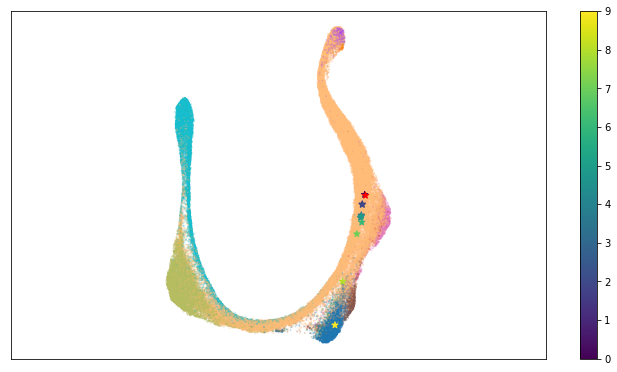

In [129]:
chain_simu(adata_test1,"68574",tnode,ns=10)

Run for test cell: 68574
Steps simulated: 80.000
Fate Bias:0.626


Neutrophil    139
Monocyte       82
Name: Annotation, dtype: int64

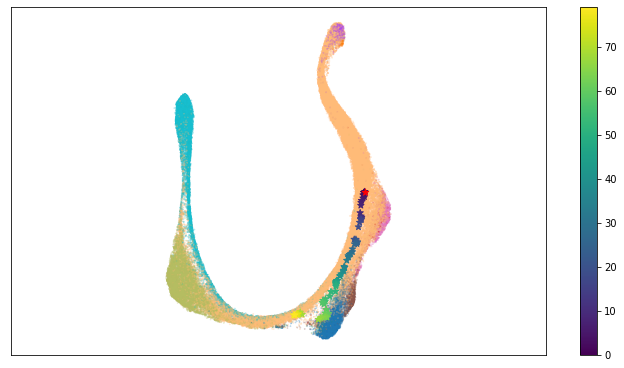

In [130]:
chain_simu(adata_test1,"68574",tnode,ns=80)

Run for test cell: 68574
Steps simulated: 120.000
Fate Bias:0.731


Neutrophil    155
Monocyte       56
Name: Annotation, dtype: int64

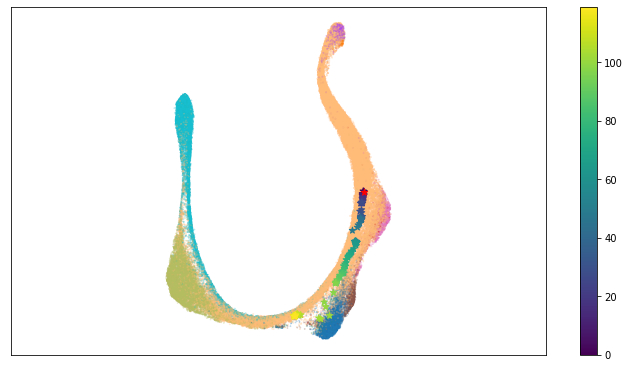

In [131]:
chain_simu(adata_test1,"68574",tnode,ns=120)

In [132]:
TestIndex = TrueTest[TrueTest].index

In [47]:
Fates = [chain_simu(adata_test1,l,tnode,plotmute=False) for l in TestIndex]

Run for test cell: 13371
Run for test cell: 13483
Run for test cell: 13760
Run for test cell: 13887
Run for test cell: 14020
Run for test cell: 14089
Run for test cell: 14106
Run for test cell: 14348
Run for test cell: 15012
Run for test cell: 15119
Run for test cell: 15182
Run for test cell: 15842
Run for test cell: 15954
Run for test cell: 16098
Run for test cell: 16179
Run for test cell: 16318
Run for test cell: 16398
Run for test cell: 16435
Run for test cell: 16447
Run for test cell: 16512
Run for test cell: 16530
Run for test cell: 16543
Run for test cell: 16801
Run for test cell: 17343
Run for test cell: 17366
Run for test cell: 17448
Run for test cell: 17464
Run for test cell: 17766
Run for test cell: 17909
Run for test cell: 18100
Run for test cell: 18235
Run for test cell: 18301
Run for test cell: 18385
Run for test cell: 18393
Run for test cell: 18519
Run for test cell: 18582
Run for test cell: 18644
Run for test cell: 18865
Run for test cell: 18889
Run for test cell: 19226


In [48]:
pickle.dump(Fates, file = open("TestFate_Prediction.pickle", "wb"))

In [49]:
SubTest = adata_test1.obs.loc[TestIndex].copy()
SubTest["fate_sctour"] = Fates

In [50]:
SubTest[["fate_sctour","neu_vs_mo_percent"]]

,fate_sctour,neu_vs_mo_percent
13371,0.515,1.0
13483,0.416,0.0
13760,0.487,0.0
13887,0.685,1.0
14020,0.571,1.0
...,...,...
61463,0.819,1.0
61520,0.000,0.0
61796,0.579,0.0
68574,0.657,1.0


In [51]:
SubTest[["fate_sctour","neu_vs_mo_percent"]].corr()

,fate_sctour,neu_vs_mo_percent
fate_sctour,1.000000,0.107825
neu_vs_mo_percent,0.107825,1.000000


In [179]:
D = adata_test1
D.obsm['X_VF'] = tnode.get_vector_field(D.obs['ptime'].values, D.obsm['X_TNODE'])
D_Sorted = D[np.argsort(D.obs['ptime'].values), :]
sc.pp.neighbors(D_Sorted, use_rep='X_TNODE', n_neighbors=50)
sc.tl.umap(D_Sorted, min_dist=0.1)

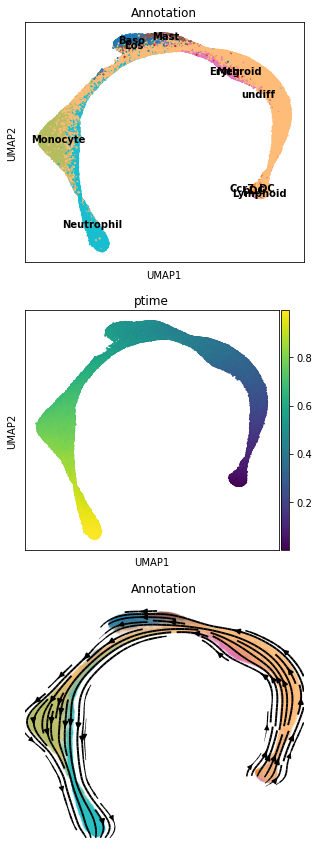

In [180]:
%matplotlib inline
fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(5, 15))
sc.pl.umap(D_Sorted, color='Annotation', size=20, ax=axs[0], legend_loc='on data', show=False)
sc.pl.umap(D_Sorted, color='ptime', size=20, ax=axs[1], show=False)
sct.vf.plot_vector_field(D_Sorted, zs_key='TNODE', vf_key='VF', use_rep_neigh='TNODE', ax=axs[2],
                         color='Annotation', t_key='ptime', legend_loc='none',reverse=True,
                         frameon=False, size=80, alpha=0.05)
plt.show()

In [3]:
test3 = pickle.load(open("/Users/ruitong/scDiffEq/scTour_Explore/tnode_20k2_l10.pickle", "rb"))

In [6]:
model = test3.get_model(None)

In [11]:
type(model.lode_func)

sctour.module.LatentODEfunc

In [8]:
odeint

<function torchdiffeq._impl.odeint.odeint(func, y0, t, *, rtol=1e-07, atol=1e-09, method=None, options=None, event_fn=None)>